# About the data

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. The classification problem is to identify the newsgroup a post was summited to, given the text of the post.

There are a few versions of this dataset from different sources online. Below, we use the version within scikit-learn which is already split into a train and test/eval set. For a longer introduction to this dataset, see the [scikit-learn website](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)

This sequence of notebooks will write files to the file system under the WORKSPACE_PATH folder. Feel free to change this location in the next cell.

In [30]:
# Note this path must be under /content in Datalab.
# It is not recommended to use paths in /content/datalab/docs
WORKSPACE_PATH = '/content/workspace/text_classification_20newsgroup'
!mkdir -p {WORKSPACE_PATH}

In [31]:
import numpy as np
import pandas as pd
import os
import re
import csv

from sklearn.datasets import fetch_20newsgroups

In [32]:
# data will be downloaded. Note that an error message saying something like "No handlers could be found for 
# logger sklearn.datasets.twenty_newsgroups" might be printed, but this is not an error.
news_train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
news_test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

# Inspecting and cleaning the raw data

The distribution of labels/newsgroups within the training and test datasets are almost uniform. But more importantly, the distribution between test and training is about the same. Note that the first column is the integer id for the newsgroup while the 2nd column is the number of text examples with this newsgroup label.

In [33]:
print('Train label distribution')
print(pd.Series(news_train_data.target).value_counts())

print('Test label distribution')
print(pd.Series(news_test_data.target).value_counts())

# The map from integer newsgroup id to its name
print(list(enumerate(news_train_data.target_names)))

Train label distribution
10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
dtype: int64
Test label distribution
10    399
8     398
15    398
9     397
11    396
7     396
13    396
5     395
14    394
2     394
12    393
3     392
6     390
1     389
4     385
17    376
16    364
0     319
18    310
19    251
dtype: int64
[(0, 'alt.atheism'), (1, 'comp.graphics'), (2, 'comp.os.ms-windows.misc'), (3, 'comp.sys.ibm.pc.hardware'), (4, 'comp.sys.mac.hardware'), (5, 'comp.windows.x'), (6, 'misc.forsale'), (7, 'rec.autos'), (8, 'rec.motorcycles'), (9, 'rec.sport.baseball'), (10, 'rec.sport.hockey'), (11, 'sci.crypt'), (12, 'sci.electronics'), (13, 'sci.med'), (14, 'sci.space'), (15, 'soc.religion.christian'), (16, 'talk.politics.guns'), (17, 'talk.politics.mideast'), (18, 'talk.politics.misc'), (19, 'talk.religion.misc')]


Printing the 3rd element in the test dataset shows the data contains text with newlines, punctuation, misspellings, and other items common in text documents. To build a model, we will clean up the text by removing some of these issues.

In [34]:
news_train_data.data[2], news_train_data.target_names[news_train_data.target[2]]


(u'well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don\'t really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is tha

In [35]:
def clean_and_tokenize_text(news_data):
    """Cleans some issues with the text data
    Args:
        news_data: list of text strings
    Returns:
        For each text string, an array of tokenized words are returned in a list
    """
    cleaned_text = []
    for text in news_data:
        x = re.sub('[^\w]|_', ' ', text)  # only keep numbers and letters and spaces
        x = x.lower()
        x = re.sub(r'[^\x00-\x7f]',r'', x)  # remove non ascii texts
        tokens = [y for y in x.split(' ') if len(y) > 1] # remove short words

        # As an exercise, try stemming each token using python's nltk package.
        cleaned_text.append(tokens)
    return cleaned_text

In [36]:
clean_train_tokens = clean_and_tokenize_text(news_train_data.data)
clean_test_tokens = clean_and_tokenize_text(news_test_data.data)

In [37]:
def get_unique_tokens_per_row(text_token_list):
    """Collect unique tokens per row.
    Args:
        text_token_list: list, where each element is a list containing tokenized text
    Returns:
        One list containing the unique tokens in every row. For example, if row one contained
        ['pizza', 'pizza'] while row two contained ['pizza', 'cake', 'cake'], then the output list
        would contain ['pizza' (from row 1), 'pizza' (from row 2), 'cake' (from row 2)]
    """
    words = []
    for row in text_token_list:
        words.extend(list(set(row)))
    return words

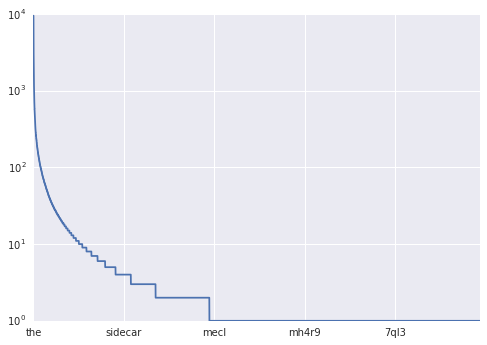

In [38]:
# Make a plot where the x-axis is a token, and the y-axis is how many text documents
# that token is in. 
words = pd.DataFrame(get_unique_tokens_per_row(clean_train_tokens) , columns=['words'])
token_frequency = words['words'].value_counts() # how many documents contain each token.
token_frequency.plot(logy=True)

Note that most of our tokens only appear in 1 document, while some appear is almost every document. To build a good model, we should remove these low and high frequency tokens.

In [39]:
len(news_train_data.data), len(token_frequency)  # There are many more tokens than examples!

(11314, 98698)

In [40]:
# As an exercise, try different ways to reduce the vocab. For example, remove
# meaningless words like 'than' or 'also'
vocab = token_frequency[np.logical_and(token_frequency < 2000, token_frequency > 17)]
print(len(vocab))

6808


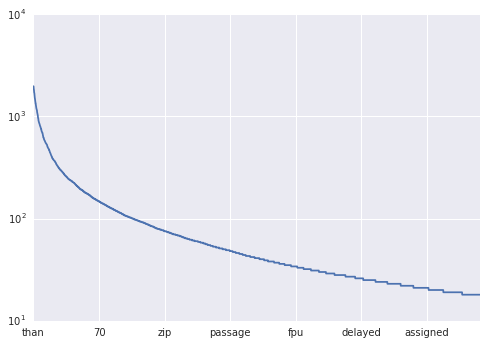

In [41]:
vocab.plot(logy=True)

In [42]:
def filter_text_by_vocab(news_data, vocab):
    """Removes tokens if not in vocab.
    Args:
        news_data: list, where each element is a token list
        vocab: set containing the tokens to keep.
    Returns:
        List of strings containing the final cleaned text data
    """
    text_strs = []
    for row in news_data:
        words_to_keep = [token for token in row if token in vocab]
        text_strs.append(' '.join(words_to_keep))
    return text_strs

In [43]:

clean_train_data = filter_text_by_vocab(clean_train_tokens, set(vocab.index))
clean_test_data = filter_text_by_vocab(clean_test_tokens, set(vocab.index))

In [44]:
# As a check, let's make sure we didn't remove any data rows.
len(clean_train_data), len(news_train_data.data), len(clean_test_data), len(news_test_data.data)

(11314, 11314, 7532, 7532)

# Save the clean data to a file

In [45]:
with open(os.path.join(WORKSPACE_PATH, 'news_clean_train.csv'), 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    for target, text in zip(news_train_data.target, clean_train_data):
        writer.writerow([news_train_data.target_names[target], text])

In [46]:
with open(os.path.join(WORKSPACE_PATH, 'news_clean_test.csv'), 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    for target, text in zip(news_test_data.target, clean_test_data):
        writer.writerow([news_test_data.target_names[target], text])

In [47]:
# Also save the vocab, but we will not use it again.
with open(os.path.join(WORKSPACE_PATH, 'vocab.txt'), 'w') as f:
    vocab.to_csv(f)